In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Example: Apple stock (AAPL)
data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
data.head()


C:\Users\hawsh\AppData\Local\Temp\ipykernel_11244\363771619.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.381001,40.390379,39.677744,39.888723,102223600
2018-01-03,40.373966,40.917820,40.310676,40.444293,118071600
2018-01-04,40.561493,40.664638,40.338796,40.446626,89738400
2018-01-05,41.023296,41.110030,40.566180,40.657604,94640000
2018-01-08,40.870941,41.166308,40.772482,40.870941,82271200


In [3]:
# Missing values check
print(data.isnull().sum())

# Agar koi missing value ho to drop kar do
data = data.dropna()

# Reset index (date ko column banane ke liye)
data.reset_index(inplace=True)
data.head()


Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2018-01-02,40.381001,40.390379,39.677744,39.888723,102223600
1,2018-01-03,40.373966,40.917820,40.310676,40.444293,118071600
2,2018-01-04,40.561493,40.664638,40.338796,40.446626,89738400
3,2018-01-05,41.023296,41.110030,40.566180,40.657604,94640000
4,2018-01-08,40.870941,41.166308,40.772482,40.870941,82271200


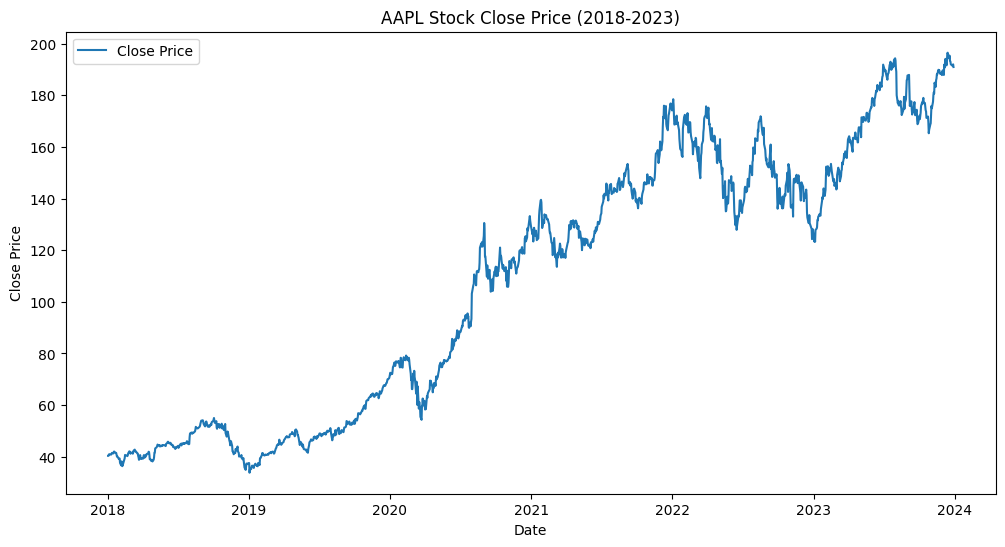

In [4]:
# Close price ka trend
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('AAPL Stock Close Price (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Close price ko select karo
close_data = data['Close'].values
close_data = close_data.reshape(-1,1)

# Scale data 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)


In [6]:
# 80% data train ke liye, 20% test ke liye
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [7]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i,0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Model define karna
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Model compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Model train
model.fit(X_train, y_train, batch_size=32, epochs=10)


Epoch 1/10


E:\stock-prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0142
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010    
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3712e-04
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.2245e-04
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9730e-04
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.2960e-04
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.8516e-04
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9281e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.2571e-04


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


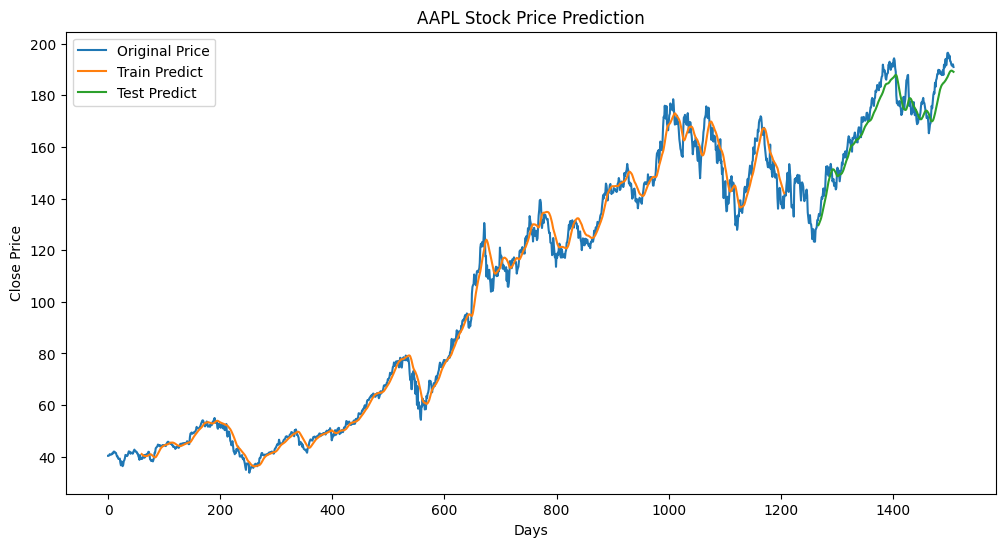

In [9]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Scale ko wapas original me convert karo
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Original close price
original = scaler.inverse_transform(scaled_data)

# Plot
plt.figure(figsize=(12,6))
plt.plot(original, label='Original Price')
plt.plot(np.arange(time_step, len(train_predict)+time_step), train_predict, label='Train Predict')
plt.plot(np.arange(len(train_predict)+(2*time_step), len(original)), test_predict, label='Test Predict')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

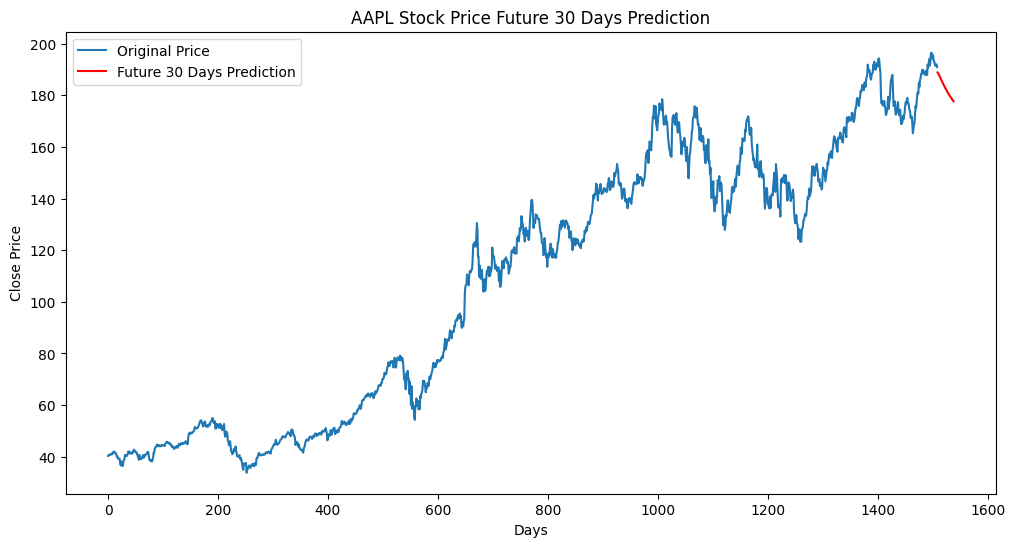

In [10]:
# Last 60 days data (model input ke liye)
last_60_days = scaled_data[-60:]
future_input = last_60_days.reshape(1, -1)
future_input = list(future_input[0])

# 30 days prediction
future_output = []
time_step = 60

for i in range(30):
    x_input = np.array(future_input[-time_step:]).reshape(1, time_step, 1)
    pred = model.predict(x_input)
    future_output.append(pred[0,0])
    future_input.append(pred[0,0])

# Scale back to original price
future_output = scaler.inverse_transform(np.array(future_output).reshape(-1,1))

# Plot future prediction
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(original)), original, label='Original Price')
plt.plot(np.arange(len(original), len(original)+30), future_output, label='Future 30 Days Prediction', color='red')
plt.title('AAPL Stock Price Future 30 Days Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [11]:
# Future prediction dates
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30)

# Create DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_output.flatten()})

# Save to CSV
future_df.to_csv('future_30_days_prediction.csv', index=False)
print("Future 30 days prediction saved as 'future_30_days_prediction.csv'")


Future 30 days prediction saved as 'future_30_days_prediction.csv'


In [14]:
!pip install plotly

In [15]:
!pip install plotly

In [16]:
import plotly.graph_objects as go

In [17]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [20]:
import plotly.graph_objects as go

# Original data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], mode='lines', name='Original Close Price'))

# Future prediction
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name='Future Prediction'))

fig.update_layout(title='AAPL Stock Price Prediction (Interactive)',
                  xaxis_title='Date', yaxis_title='Close Price',
                  template='plotly_dark')
fig.show()

In [21]:
import plotly.io as pio
pio.renderers.default = 'notebook'

In [22]:
pio.renderers.default = 'notebook_connected'

In [24]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], mode='lines', name='Original Close Price'))
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name='Future Prediction'))

fig.update_layout(title='AAPL Stock Price Prediction (Interactive)',
                  xaxis_title='Date', yaxis_title='Close Price',
                  template='plotly_dark')
fig.show()